# Exemple d'analyse d'un dataset : le Titanic

** Exemple de données qualitatives **

In [1]:
# Directive pour afficher les graphiques dans Jupyter
%matplotlib inline

In [2]:
# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
# SeaBorn : librairie de graphiques avancés
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Une alternative à la lecture directe du fichier est d'utiliser une url de téléchargement du dataset
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic = pd.read_csv(url)

In [4]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Interprétation des paramètres

In [5]:
# Suppression des informations non pertinentes
t = titanic.drop(['name','ticket'], axis=1)
t.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


# Rose & Jack

*value_counts* permet de compter le nombre d'éléments par catégorie d'une série

In [6]:
t.sex.value_counts()      # nombre d'hommes et de femmes

male      577
female    314
Name: sex, dtype: int64

In [7]:
t.sex.count()              # nombre total hommes+femmes

891

In [8]:
t.cabin.count()

204

In [9]:
t.count()                  # Comptage par colonnes

survived    891
pclass      891
sex         891
age         714
sibsp       891
parch       891
fare        891
cabin       204
embarked    889
dtype: int64

On remarque qu'il manque des valeurs pour 'age' et 'embarked' (présence de valeurs indéfinies 'NaN')

On peut définir un booléen pour abréger une caractéristique :

In [10]:
hommes = (t.sex=="male")

In [11]:
t[hommes].head()        # t[hommes] est le tableau où on ne retient que lignes pour lesquelles hommes est True

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
5,0,3,male,NaN,0,0,8.4583,NaN,Q
6,0,1,male,54.0,0,0,51.8625,E46,S
7,0,3,male,2.0,3,1,21.0750,NaN,S


On peut compter les hommes survivants ou non :

In [12]:
t[hommes].survived.value_counts()

0    468
1    109
Name: survived, dtype: int64

## Exercice : quelle est la probabilité de survie de Rose et Jack ?

<img src="https://www.scienceabc.com/wp-content/uploads/2016/04/titanic-jack-and-rose-plank-scene.webp">

In [13]:
femmes = t.sex=="female"
classe1 = t.pclass == 1
classe2 = t.pclass == 2
classe3 = t.pclass == 3
survivant = t.survived == 1
mort = ~ survivant

Jack est un homme en 3ème classe, et Rose une femme en 1ère :

In [14]:
jack = hommes & classe3
rose = femmes & classe1

In [15]:
p_jack = t[jack & survivant].sex.count()/float(t[jack].sex.count())
print(p_jack)

0.135446685879


In [16]:
p_rose = t[rose & survivant].sex.count()/float(t[rose].sex.count())
print(p_rose)

0.968085106383


## Enrichissement du dataset

l'opérateur *map* permet de transformer les valeurs d'une série. Par exemple, si on veut donner des valeurs explicites à la classe, on peut créer une **nouvelle colonne** *classe* :

In [17]:
t['classe'] = t.pclass.map({1: "Premiere", 2: "Seconde", 3: "Troisieme"})

In [18]:
t.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,classe
0,0,3,male,22.0,1,0,7.2500,NaN,S,Troisieme
1,1,1,female,38.0,1,0,71.2833,C85,C,Premiere
2,1,3,female,26.0,0,0,7.9250,NaN,S,Troisieme
3,1,1,female,35.0,1,0,53.1000,C123,S,Premiere
4,0,3,male,35.0,0,0,8.0500,NaN,S,Troisieme


On peut aussi créer une colonne qui indique si un passager voyage *seul* ou non :

In [19]:
t['seul'] = ~(t.parch + t.sibsp).astype(bool)
# astype(bool) convertit le type en booléen
# qui est donc True si la somme des freres/soeurs/conjoint et enfants/parents est 0 

Le *deck* (étage du navire) est indiqué par la première lettre de l'identifiant de cabine (par exemple la C85 est au deck C).  
On utilise la fonction *lambda* pour récupérer la valeur de l'objet appelant (ici *s* est la première lettre de l'identifiant cabine) :

In [20]:
t['deck'] = t.cabin.str[0].map(lambda s: np.nan if s == "T" else s)

On veut maintenant créer une colonne indiquant si un passager est un enfant, une femme ou un homme.  
On commence par écrire une fonction en python :

In [21]:
def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        if sex=="male": return "man"
        else: return "woman"

L'opérateur *apply* permet alors d'appliquer la fonction à toutes les lignes :

In [22]:
t['qui'] = t[['age', 'sex']].apply(woman_child_or_man, axis=1)

In [23]:
t.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,classe,seul,deck,qui
0,0,3,male,22.0,1,0,7.2500,NaN,S,Troisieme,False,NaN,man
1,1,1,female,38.0,1,0,71.2833,C85,C,Premiere,False,C,woman
2,1,3,female,26.0,0,0,7.9250,NaN,S,Troisieme,True,NaN,woman
3,1,1,female,35.0,1,0,53.1000,C123,S,Premiere,False,C,woman
4,0,3,male,35.0,0,0,8.0500,NaN,S,Troisieme,True,NaN,man


## Graphiques

On veut visualiser le nombre de survivants par sexe :

In [24]:
nb_survivants_par_sexe = t[survivant].qui.value_counts().sort_index()
nb_survivants_par_sexe

child     49
man       88
woman    205
Name: qui, dtype: int64

([<matplotlib.patches.Wedge at 0x2ab244c99e8>,
 [Text(0.990439,0.478572,'enfants'),
  Text(-0.151089,1.08957,'hommes'),
  Text(-0.337996,-1.04678,'femmes')])

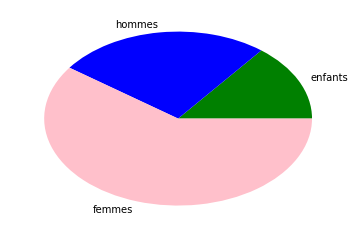

In [25]:
# Diagramme en "camembert"
plt.pie(nb_survivants_par_sexe, labels = ['enfants','hommes','femmes'], colors = ['green','blue','pink'])

Ou le nombre de survivants par classe sous la forme d'un diagramme à barres :

<Container object of 3 artists>

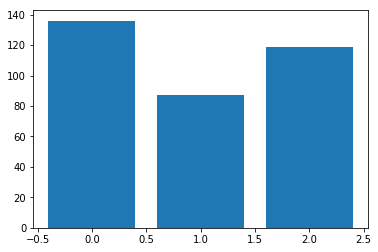

In [26]:
nb_survivants_par_classe = t[survivant].pclass.value_counts().sort_index() # sort_index trie par valeurs croissantes
plt.bar(range(3),nb_survivants_par_classe)

On peut superposer les hitogrammes des hommes et des femmes par âge (*alpha=0.5* pour une transparence à 50%)

D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


(array([ 12.,  12.,   8.,  11.,  32.,  26.,  32.,  33.,  22.,  19.,  15.,
         11.,  12.,   7.,   5.,   4.,   0.,   0.,   0.,   0.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.]),
 <a list of 20 Patch objects>)

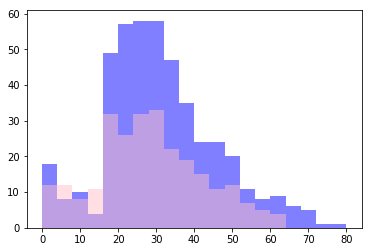

In [27]:
plt.hist(t[hommes].age, range=(0,80), bins=20, color='blue', alpha=0.5)
plt.hist(t[femmes].age, range=(0,80), bins=20, color='pink', alpha=0.5)

**seaborn** permet des graphiques  plus sophistiqués

Par exemple le graphique de la répartition des passagers par sexe et par classe :

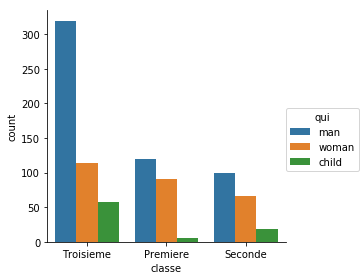

In [28]:
sns.factorplot("classe", data=t, hue="qui", kind="count")

ou, avec une autre écriture, le graphique de la répartition des survivants par sexes et par classe :

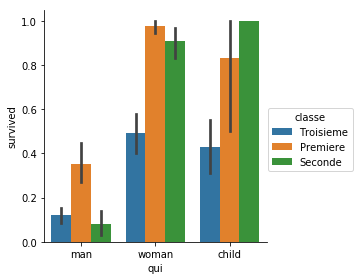

In [29]:
sns.factorplot(x="qui", y="survived", hue="classe", data=t, kind="bar")

Les **diagrammes en boîte** (ou **boîtes à moustaches** ou **box plot**) résument quelques caractéristiques de position du caractère étudié (médiane, quartiles, minimum, maximum ou déciles). Ce diagramme est utilisé principalement pour comparer un même caractère dans deux populations de tailles différentes. Il s'agit de tracer un rectangle allant du premier quartile au troisième quartile et coupé par la médiane. On ajoute alors des segments aux extrémités menant jusqu'aux valeurs extrêmes.  
Par exemple pour la répartion de l'âge des passagers selon la classe et le sexe :

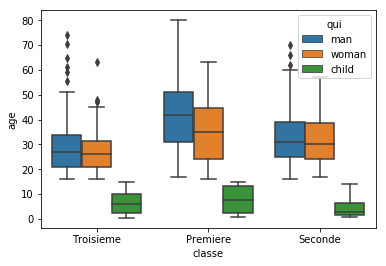

In [30]:
sns.boxplot(x="classe", y="age", hue="qui", data=t)

Les **violins plots** sont similaires aux box plots, excepté qu’ils permettent de montrer la courbe de densité de probabilité des différentes valeurs. Typiquement, les violins plots présentent un marqueur pour la médiane des données et l’écart interquartile, comme dans un box plot standard.

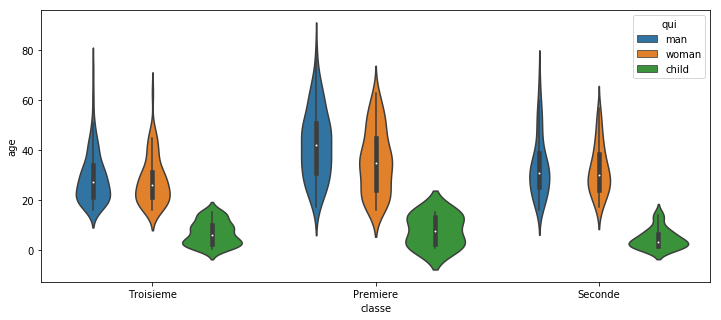

In [31]:
plt.figure(figsize=(12,5))
sns.violinplot(x="classe", y="age", hue="qui", data=t)

Une variante de présentation, pour le graphique de répartition du prix du ticket selon la classe :

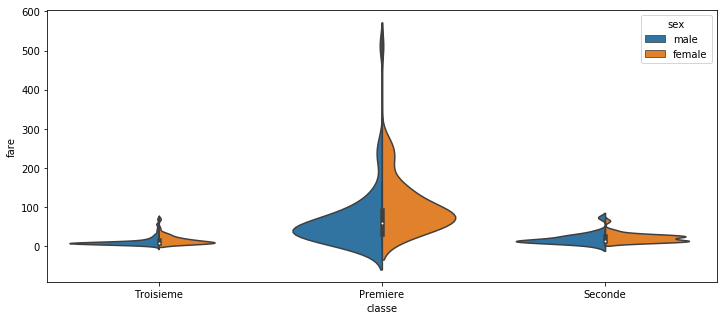

In [32]:
plt.figure(figsize=(12,5))
sns.violinplot(x="classe", y="fare", hue="sex", data=t, split=True)

*FacetGrid* permet de superposer des graphiques selon une ou plusieurs caractéristiques. On crée une structure avec *FacetGrid*, et on trace ensuite les graphiques avec *map*

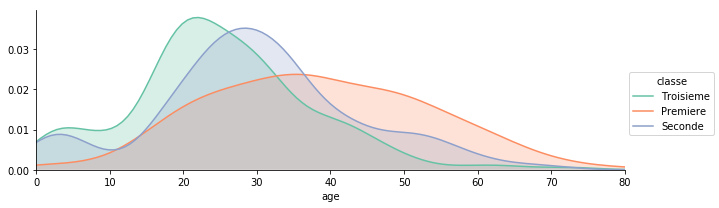

In [33]:
fig = sns.FacetGrid(t, hue="classe", aspect=3, palette="Set2") # aspect=3 permet d'allonger le graphique
fig.map(sns.kdeplot, "age", shade=True)
fig.add_legend()
fig.set(xlim=(0, 80))

**Note :** Les couleurs par défaut sont souvent peu esthétiques ... On peut utiliser des palettes de couleurs, prédéfinies ou non ("Set1", "Set2", "Set3", "Blues", "Colorblind", ...).  
Cf par exemple :  
http://seaborn.pydata.org/tutorial/color_palettes.html  
https://chrisalbon.com/python/seaborn_color_palettes.html  

On peut faire également un tableau de graphique, par exemple afficher les distributions par âge, selon le sexe et la classe :

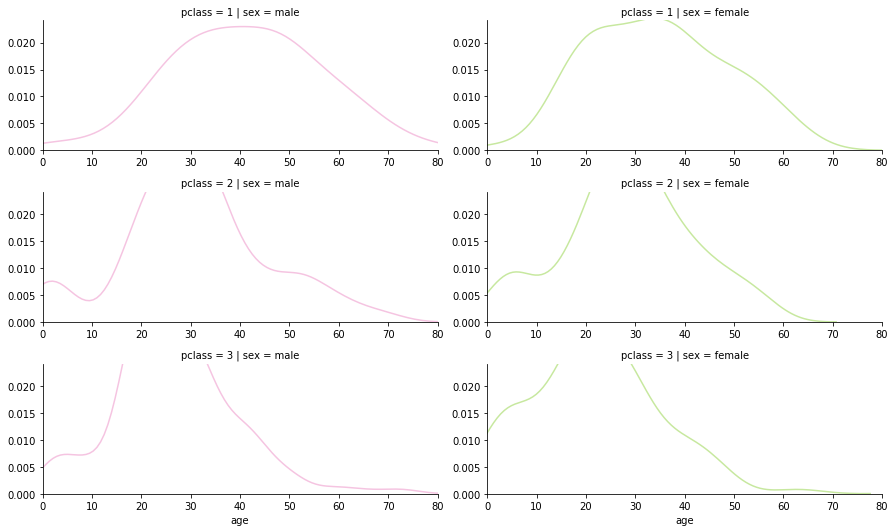

In [34]:
fg = sns.FacetGrid(titanic, col="sex", row="pclass", hue="sex", size=2.5, aspect=2.5, palette="PiYG")
fg.map(sns.kdeplot, "age")
fg.set(xlim=(0, 80));

On peut aussi tracer des courbes de régression, pour évaluer par exemple la probabilité de survie :

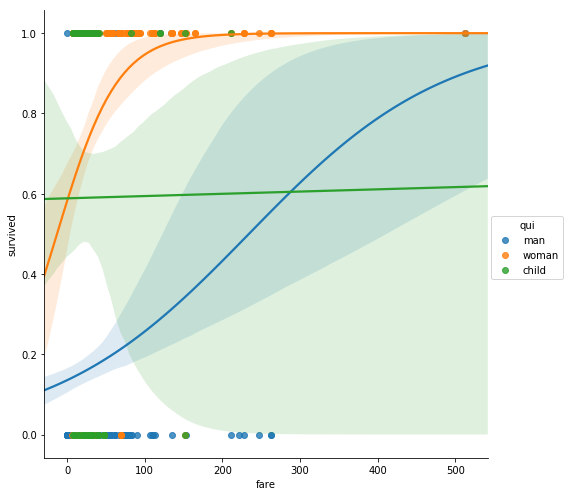

In [35]:
sns.lmplot(x='fare', y='survived', hue="qui", data=t, size=7, logistic=True)

On voit que la probabilité de survie des femmes augmente rapidement avec le prix du ticket, ce qui n'est pas le cas de hommes. Le prix a peu d'influence sur la survie des enfants

Pour plus de détails sur les grilles de graphiques :  
http://seaborn.pydata.org/tutorial/axis_grids.html